In [ ]:
import pandas as pd
import re
from collections import Counter
from itertools import chain
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

select major keyword

In [2]:
def find_best_match(text, pre_keywords, post_keywords):
    def find_non_overlapping_positions(keywords, text):
        """ Find non-overlapping keyword positions in text, prioritizing longer keywords. """
        sorted_keywords = sorted(keywords, key=len, reverse=True)
        positions = []
        modified_text = text
        offset = 0

        for kw in sorted_keywords:
            for match in re.finditer(re.escape(kw), modified_text):
                start = match.start() + offset
                positions.append((kw, start))
                modified_text = modified_text[:match.start()] + " " * len(kw) + modified_text[match.end():]
                offset += len(kw) - len(kw)  
        
        return positions

    pre_positions = find_non_overlapping_positions(pre_keywords, text)
    post_positions = find_non_overlapping_positions(post_keywords, text)

    if not pre_positions and not post_positions:
        return "", "", ""

    post_positions_sorted = sorted(post_positions, key=lambda x: x[1])

    if len(post_positions) > 1 and len(pre_positions) == 1:
        pre_kw, pre_pos = pre_positions[0]
        second_post_kw, second_post_pos = post_positions_sorted[1]
        
        if pre_pos <= second_post_pos:
            match_text = text[pre_pos: second_post_pos + len(second_post_kw)].strip()
            return match_text, pre_kw, second_post_kw

    if post_positions and not pre_positions:
        first_post_kw, first_post_pos = post_positions_sorted[0]
        
        if len(post_positions_sorted) > 1:
            second_post_kw, second_post_pos = post_positions_sorted[1]
        else:
            second_post_kw, second_post_pos = post_positions_sorted[0]

        match = re.search(r"[。；]", text[:first_post_pos][::-1])
        if match:
            sentence_start = first_post_pos - match.start() - 1
        else:
            sentence_start = 0

        match_text = text[sentence_start: second_post_pos + len(second_post_kw)].strip()
        return match_text, "", second_post_kw

    if pre_positions and post_positions:
        best_match = None
        min_distance = float('inf')

        for pre_kw, pre_pos in pre_positions:
            for post_kw, post_pos in post_positions_sorted:
                if pre_pos <= post_pos and (post_pos - pre_pos) < min_distance:
                    best_match = (text[pre_pos: post_pos + len(post_kw)].strip(), pre_kw, post_kw)
                    min_distance = post_pos - pre_pos

        return best_match if best_match else ("", "", "")

    return "", "", ""

def extract_degree_requirements(sentence, degree_keywords):
    """ Extracts degree-related keywords from a given sentence. """
    sorted_keywords = sorted(degree_keywords, key=len, reverse=True)
    matched = []
    remaining_sentence = sentence
    
    for kw in sorted_keywords:
        if kw in remaining_sentence:
            matched.append(kw)
            remaining_sentence = re.sub(re.escape(kw), "", remaining_sentence, count=1)

    final_matched = set()
    for item in matched:
        split_degrees = re.split(r' 或 |/|,|，', item)
        final_matched.update(split_degrees)

    return "，".join(final_matched) if final_matched else ""

def process_job_data(job_data, pre_keywords, post_keywords, degree_keywords):
    """ Process job postings to extract relevant degree requirements based on keywords. """
    results = []
    
    for index, row in job_data.iterrows():
        text = row['职位信息']
        matched_sentence, pre_kw, post_kw = find_best_match(text, pre_keywords, post_keywords)
        
        if matched_sentence:
            degree_match = extract_degree_requirements(matched_sentence, degree_keywords)
        else:
            matched_sentence, pre_kw, post_kw, degree_match = "", "", "", ""
        
        row_data = row.to_dict()
        row_data.update({
            "匹配句子": matched_sentence,
            "前标志词": pre_kw,
            "后标志词": post_kw,
            "学位要求": degree_match
        })
        results.append(row_data)
    
    return pd.DataFrame(results)


In [3]:
# Read data (assuming the data is in a CSV file)
job_data = pd.read_csv("1000jobs.csv")  # Contains job_title and other relevant information

# Re-load the reference Excel file
reference_file = "table1.xlsx"
reference_xls = pd.ExcelFile(reference_file)

# Load sheets
pre_keywords = reference_xls.parse('前标志词')['前标志词'].tolist()
post_keywords = reference_xls.parse('后标志词')['后标志词'].tolist()
degree_keywords = reference_xls.parse('学位要求')['学位要求'].tolist()

# Process data
result_df = process_job_data(job_data, pre_keywords, post_keywords, degree_keywords)

# Display results
display(result_df)

,任务网址,职位信息,分词,匹配句子,前标志词,后标志词,学位要求
0,https://jobs.51job.com/kunshan/144359410.html,岗位职责：【不需要露脸】1、与粉丝互动，遵循公司与平台的规章制度，进行绿色健康的直播；2、年...,"主播,）,善于,能,文案,技巧,观众,推荐,直播,趣味性,该,优秀,奖励,6K,情绪,抗压性...",,,,
1,https://jobs.51job.com/kunshan/143185309.html,从事项目工程技术管理工作，主要职责为测量放样、制图审核、施工管理、资料编制、方案编制等。,"。,方案,工程技术,施工,等,资料,制图,，,管理,编制,审核,、,项目,放样,从事,为,测...",,,,
2,https://jobs.51job.com/kunshan/153875372.html,【配送流程】：1.客户通过网上下单，根据地址打开手机导航骑店里电瓶车配送到客户家里。2.门店...,"月均,奖,）,元,能,可,.,50,元起,600,站,日均,门店,*,电瓶车,接着,正常,万...",,,,
3,https://jobs.51job.com/kunshan/153238159.html,1.负责蔬菜生鲜超市百货商品配送，驻点配送，不用跑商家节省时间2.单量超级多，长期稳定；3....,"）,费用,元,可,.,50,大,日均,待遇,*,9000,节省时间,超市,直接,、,经理,多...",,,,
4,https://jobs.51job.com/kunshan/153344919.html,岗位职责：1.自动化项目的售前支持；2.自动化项目电气方案设计和电气元器件选型；3.自动化项...,"年会,奖,交办,）,休假日,能,组装,住房,拓展,.,及其,养老保险,至,电气控制,每年,年...",；任职资格：1.电气工程及其自动化或自动化相关专业本科以上学历,,以上学历,电气
...,...,...,...,...,...,...,...
995,https://jobs.51job.com/kunshan/149528822.html,岗位职责1、完成大区经理下达的销售任务和考核指标；2、完成区域内空白市场的开发；3、协助区域...,"具备,。,开发,合理性,费用,开拓,考核,强,真实性,任务,及动销,团队,确保,以上,；,同...",,,,
996,https://jobs.51job.com/kunshan/140048834.html,一、工作职责1. 负责联系专家学者，组织稿件的同行评审，确保稿件的同行评审及时完成；2. 编...,"肿瘤学,津贴,稿件,作者,营养,统计学,微生物,步行,能,.,年,节日,站,奖励,联系,编委...",。二、职位要求1. 流行病与卫生统计学，卫生毒理学，免疫学，病原生物学，病理学与病理生理学，...,,以上学历,药学，生物
997,https://jobs.51job.com/kunshan/142650224.html,岗位职责？1、按ISO9000管理标准维护并持续改进公司的质量管理体系；2、组织实施工厂内部...,"）,任务,年,实践,部门,、,ISO,工作,以上学历,QA,办公,工厂,与,合作,内,标准,...",。？任职资格？1、相关专业本科以上学历,,以上学历,
998,https://jobs.51job.com/kunshan/152831675.html,(一)岗位职责:1.维护和推动连锁、片区、门店合作关系，确保销售目标有效达成；2.制定和实施...,"有效,）,消费者,客情,符合,.,推荐,年,利益,门店,关系,、,及,工作,目标,(,医药,...",岗位要求：1.全日制大专以上学历，医学、药学、医药营销相关专业,岗位要求,相关专业,药学


merge major

In [4]:
matching = reference_xls.parse('matching')

In [5]:
# Construct mapping dictionary
degree_to_category = dict(zip(matching['学位要求'], matching['本科专业类别']))

def map_degree_to_category(degree_str):
    # Split by Chinese comma and remove leading/trailing spaces
    degrees = [d.strip() for d in degree_str.split('，')]
    # Use dict.fromkeys to remove duplicates while preserving order
    categories = list(dict.fromkeys(degree_to_category[d] for d in degrees if d in degree_to_category))
    # Join results using a Chinese comma and return
    return '，'.join(categories)

# Apply function
result_df['本科专业类别'] = result_df['学位要求'].apply(map_degree_to_category)

result_df.head(5)

,任务网址,职位信息,分词,匹配句子,前标志词,后标志词,学位要求,本科专业类别
0,https://jobs.51job.com/kunshan/144359410.html,岗位职责：【不需要露脸】1、与粉丝互动，遵循公司与平台的规章制度，进行绿色健康的直播；2、年...,"主播,）,善于,能,文案,技巧,观众,推荐,直播,趣味性,该,优秀,奖励,6K,情绪,抗压性...",,,,,
1,https://jobs.51job.com/kunshan/143185309.html,从事项目工程技术管理工作，主要职责为测量放样、制图审核、施工管理、资料编制、方案编制等。,"。,方案,工程技术,施工,等,资料,制图,，,管理,编制,审核,、,项目,放样,从事,为,测...",,,,,
2,https://jobs.51job.com/kunshan/153875372.html,【配送流程】：1.客户通过网上下单，根据地址打开手机导航骑店里电瓶车配送到客户家里。2.门店...,"月均,奖,）,元,能,可,.,50,元起,600,站,日均,门店,*,电瓶车,接着,正常,万...",,,,,
3,https://jobs.51job.com/kunshan/153238159.html,1.负责蔬菜生鲜超市百货商品配送，驻点配送，不用跑商家节省时间2.单量超级多，长期稳定；3....,"）,费用,元,可,.,50,大,日均,待遇,*,9000,节省时间,超市,直接,、,经理,多...",,,,,
4,https://jobs.51job.com/kunshan/153344919.html,岗位职责：1.自动化项目的售前支持；2.自动化项目电气方案设计和电气元器件选型；3.自动化项...,"年会,奖,交办,）,休假日,能,组装,住房,拓展,.,及其,养老保险,至,电气控制,每年,年...",；任职资格：1.电气工程及其自动化或自动化相关专业本科以上学历,,以上学历,电气,电气类


In [6]:
# Save result
result_df1 = result_df[result_df['本科专业类别'] != ""]
result_df1.to_csv('major_job_match.csv', index = False)

visualization

In [ ]:
# Chinese character
plt.rcParams['font.family'] = 'Arial Unicode MS'  
plt.rcParams['axes.unicode_minus'] = False  

/var/folders/jr/0m0wy9490ynf5ppbg3ldz7100000gn/T/ipykernel_33101/490132283.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=job_data, x="本科专业类别", order=job_data["本科专业类别"].value_counts().index, palette="Blues")


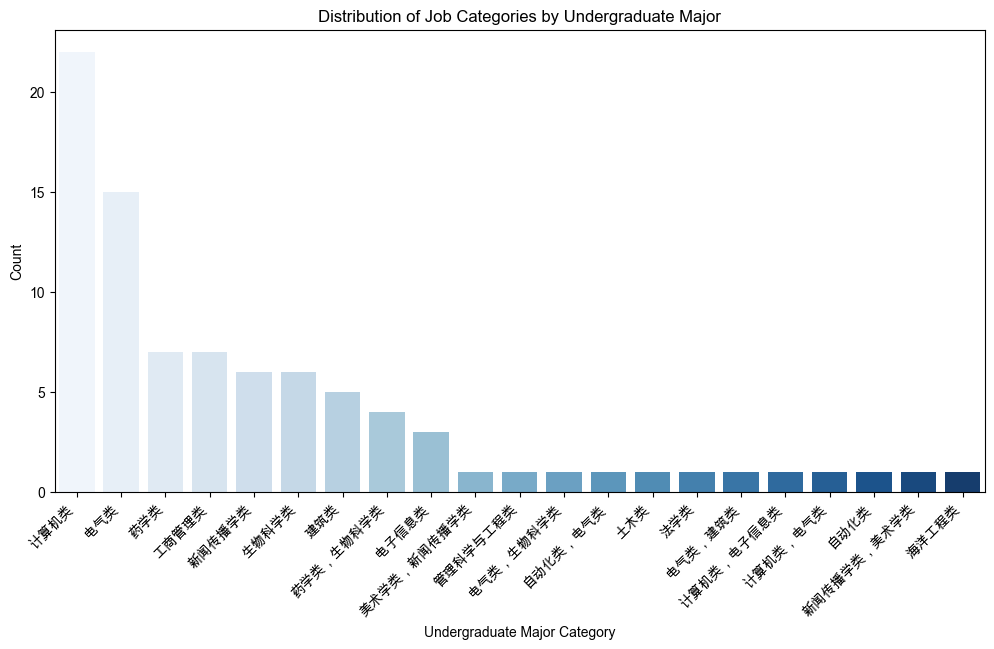

In [12]:
job_data = result_df1
# Job category distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=job_data, x="本科专业类别", order=job_data["本科专业类别"].value_counts().index, palette="Blues")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Undergraduate Major Category")
plt.ylabel("Count")
plt.title("Distribution of Job Categories by Undergraduate Major")
plt.show()


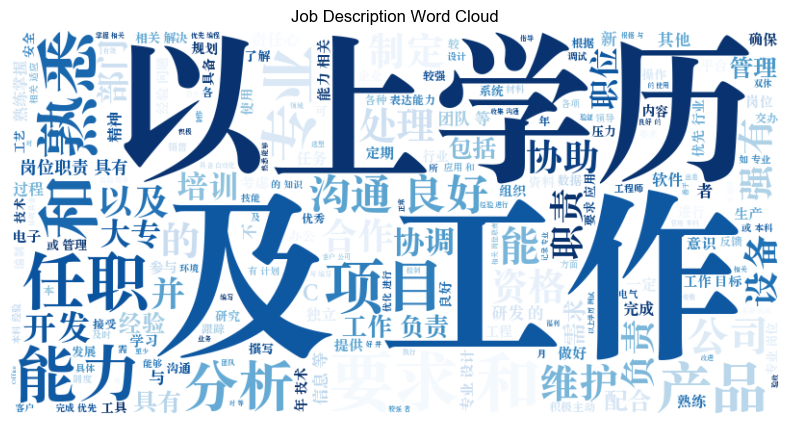

In [16]:
# Set the font path for proper Chinese character display
font_path = "/System/Library/Fonts/Supplemental/Songti.ttc"  # macOS
# font_path = "C:/Windows/Fonts/simhei.ttf"  # Windows

# Extract and process the segmented words column
text_data = " ".join(job_data["分词"].dropna().astype(str))  # Join all words

# Replace commas with spaces to properly format the text for word cloud
text_data = text_data.replace(",", " ")

# Generate the word cloud
wordcloud = WordCloud(
    font_path=font_path,  # Ensure correct font for Chinese
    width=800, 
    height=400, 
    background_color="white", 
    colormap="Blues"
).generate(text_data)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Job Description Word Cloud")
plt.show()